# `StableReparam` posteriors

This notebook examines the posteriors over the four latent variables introduced by `StableReparam`, conditioned on a single datum and the `Stable` parameters. Our goal is to assess the accuracy of an `AutoNormal` approximation to this posterior, addressing [Pyro issue #3280](https://github.com/pyro-ppl/pyro/issues/3280).

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.reparam import StableReparam
from pyro.nn.module import PyroModule, PyroParam
from pyro.optim import ClippedAdam
import matplotlib as mpl
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(20231006)
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
stability = 1.9
skew = 0.5
scale = 1.0
loc = 0.0
stable = dist.Stable(stability, skew, scale, loc)

In [3]:
@poutine.reparam(config={"x": StableReparam()})
def model(data: torch.Tensor):
    with pyro.plate("data", len(data)):
        pyro.sample("x", stable, obs=data)

Let's sample some representative points.

In [4]:
data = stable.sample([10001])
data, _ = data.sort()
data.shape

torch.Size([10001])

Text(0.5, 1.0, 'Approximate CDF')

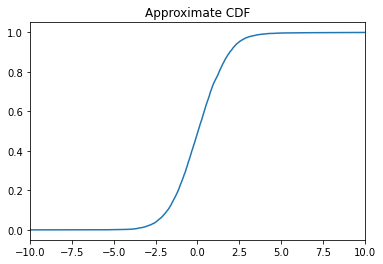

In [5]:
plt.plot(data, torch.linspace(0, 1, len(data)))
plt.xlim(-10, 10)
plt.title("Approximate CDF")

In [6]:
quantiles = torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0])

In [7]:
# draw samples using Pyro's NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=4000, warmup_steps=400)
mcmc.run(quantiles)
samples = mcmc.get_samples()

Warmup:   0%|                                                                                                    | 0/4400 [00:00, ?it/s]

Sample: 100%|████████████████████████████████████████| 4400/4400 [01:23, 52.44it/s, step size=1.96e-01, acc. prob=0.914]                


In [11]:
{k: v.shape for k, v in sorted(samples.items())}

{'x_t_exponential': torch.Size([4000, 5]),
 'x_t_uniform': torch.Size([4000, 5]),
 'x_z_exponential': torch.Size([4000, 5]),
 'x_z_uniform': torch.Size([4000, 5])}

In [12]:
z = torch.stack([v for k, v in sorted(samples.items())], dim=-1)
z.shape

torch.Size([4000, 5, 4])

In [13]:
mcmc.transforms

{'x_z_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_z_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 ),
 'x_t_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_t_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 )}

In [16]:
z_unconstrained = torch.stack(
    [mcmc.transforms[k](v) for k, v in sorted(samples.items())],
    dim=-1
)

In [43]:
def plot_pairs(data_index: int, z_unconstrained) -> None:
    """lots a 4x4 grid of pairwise scatter plots for each of the four dimensions"""
    samples = z_unconstrained[:, data_index, :].numpy()
    assert samples.shape == (len(samples), 4)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            if i == j:
                axs[i, j].hist(samples[:, i], bins=50, lw=0)
                # draw a smoothed histogram
            else:
                axs[i, j].scatter(samples[:, j], -samples[:, i], s=5, alpha=0.3, lw=0)
            if i < 3:
                axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    fig.suptitle(f"reparam z | x = {quantiles[data_index]:0.5g}", fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)

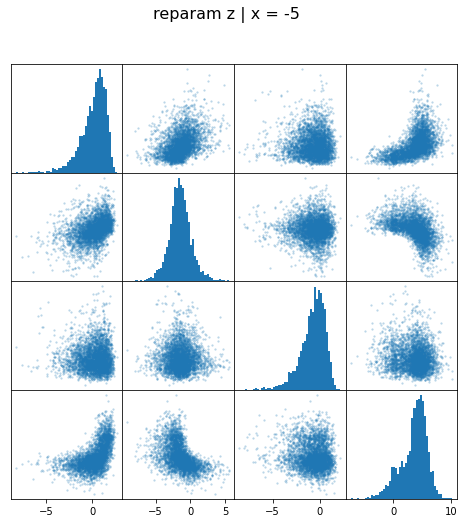

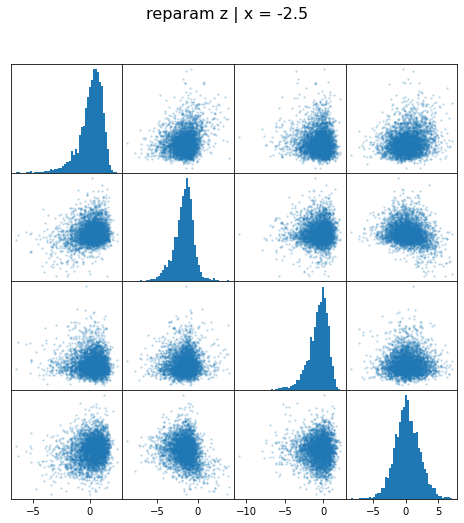

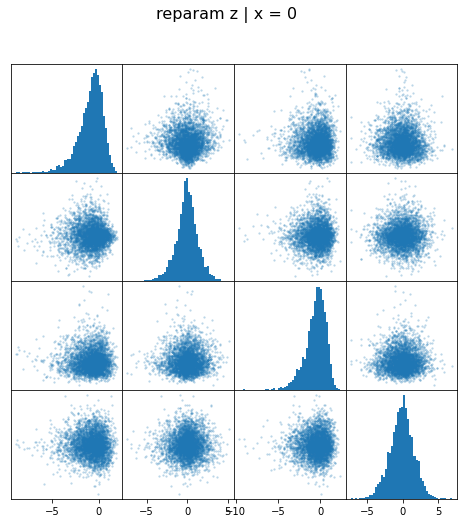

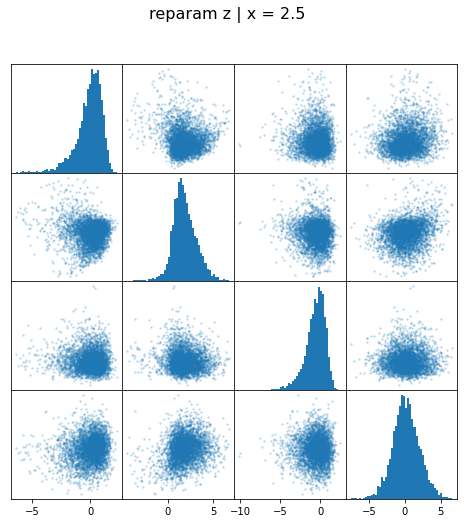

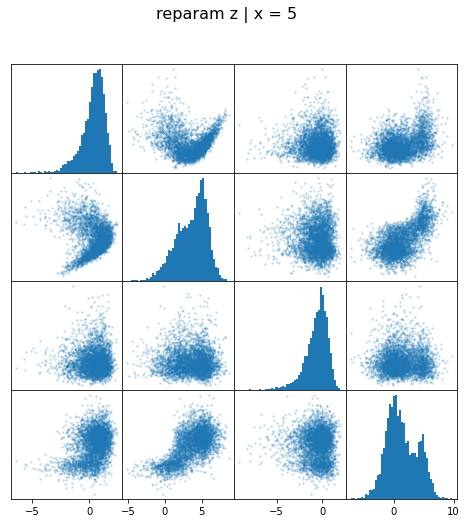

In [44]:
for i in range(len(quantiles)):
    plot_pairs(i, z_unconstrained)

## Fitting an amortized guide

Let's fit an amortized diagonal normal guide, in preparation for more complex guides.

In [19]:
pyro.set_rng_seed(20231007)
data = stable.sample([100000])

In [40]:
class AmortizedNormalGuide(PyroModule):
    def __init__(self, data: torch.Tensor, hidden_dim=10):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim, 2 * 4),
        )

        # Initialize to zero mean, small variance.
        with torch.no_grad():
            mean = self.net(data[..., None]).mean(dim=0)
            self.net[-1].bias.data -= mean
            self.net[-1].bias.data[4:] -= 5

    def forward(self, data: torch.Tensor):
        loc, scale = self.net(data[..., None]).chunk(2, dim=-1)
        scale = torch.nn.functional.softplus(scale)
        with pyro.plate("data", len(data)):
            z_unconstrained = pyro.sample(
                "z_unconstrained",
                dist.Normal(loc, scale).to_event(1),
                infer={"is_auxiliary": True},
            )
            trans_u = dist.transforms.SigmoidTransform()
            trans_e = dist.transforms.SoftplusTransform()
            z_u, z_e, t_u, t_e = z_unconstrained.unbind(-1)
            z_u_ = trans_u(z_u)
            z_e_ = trans_e(z_e)
            t_u_ = trans_u(t_u)
            t_e_ = trans_e(t_e)
            pyro.sample("x_z_uniform", dist.Delta(z_u_, log_density=trans_u.inv.log_abs_det_jacobian(z_u_, z_u)))
            pyro.sample("x_z_exponential", dist.Delta(z_e_, log_density=trans_e.inv.log_abs_det_jacobian(z_e_, z_e)))
            pyro.sample("x_t_uniform", dist.Delta(t_u_, log_density=trans_u.inv.log_abs_det_jacobian(t_u_, t_u)))
            pyro.sample("x_t_exponential", dist.Delta(t_e_, log_density=trans_e.inv.log_abs_det_jacobian(t_e_, t_e)))
        return z_unconstrained
        

step:    0 loss: 24.3
step:  100 loss: 15.553
step:  200 loss: 8.1565
step:  300 loss: 4.9637
step:  400 loss: 4.3733
step:  500 loss: 4.413
step:  600 loss: 4.2549
step:  700 loss: 4.7478
step:  800 loss: 4.587
step:  900 loss: 4.7133
step: 1000 loss: 4.6237
step: 1100 loss: 4.7956
step: 1200 loss: 5.0199
step: 1300 loss: 4.6974
step: 1400 loss: 4.4943
step: 1500 loss: 4.4831
step: 1600 loss: 4.5747
step: 1700 loss: 4.5534
step: 1800 loss: 4.4017
step: 1900 loss: 4.2952
step: 2000 loss: 4.3322


(3.9776323207255597, 24.300397812754767)

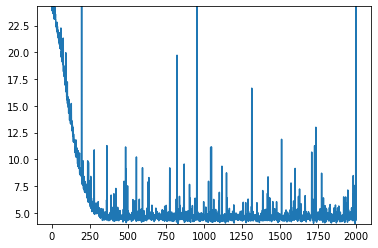

In [41]:
pyro.clear_param_store()
pyro.set_rng_seed(20231007)

num_steps = 2001
guide = AmortizedNormalGuide(data)
elbo = Trace_ELBO()
optim = ClippedAdam({"lr": 0.002, "lrd": 0.1**(1 / num_steps)})
svi = SVI(model, guide, optim, elbo)
losses = []
for step in range(num_steps):
    batch = data[torch.randint(len(data), (100,))]
    loss = svi.step(batch) / len(batch)
    losses.append(loss)
    if step % 100 == 0:
        print(f"step: {step: >4d} loss: {loss:0.5g}")

plt.plot(losses)
plt.ylim(min(losses), losses[0])

In [47]:
with torch.no_grad(), pyro.plate("samples", 4000, dim=-2):
    z_unconstrained_svi = guide(quantiles)
z_unconstrained_svi.shape

torch.Size([4000, 5, 4])

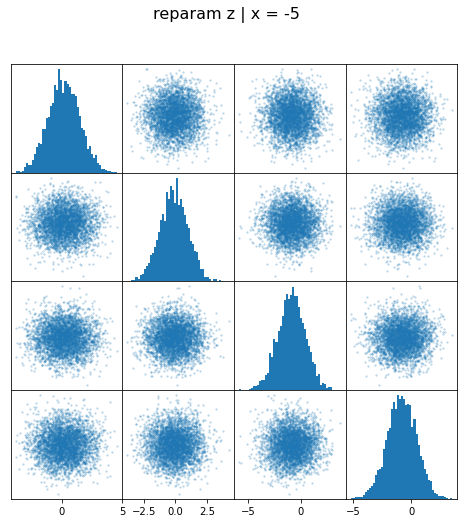

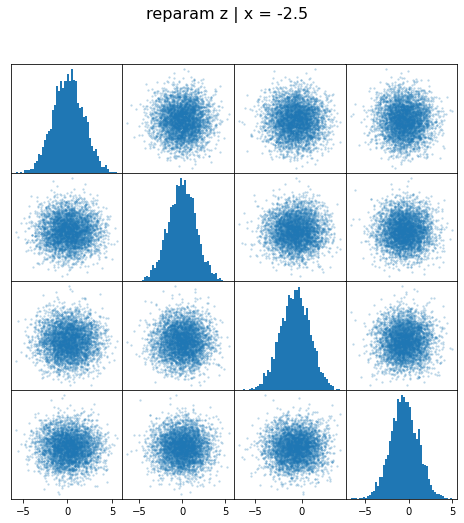

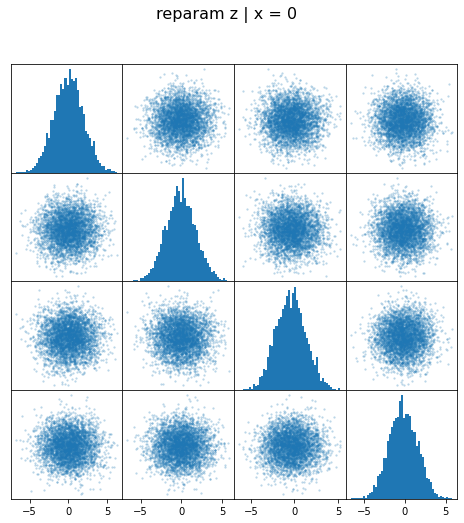

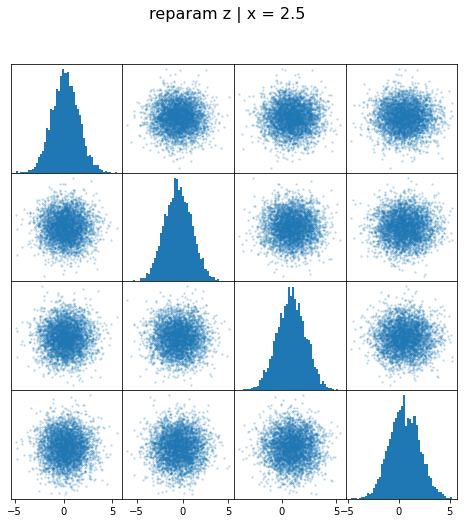

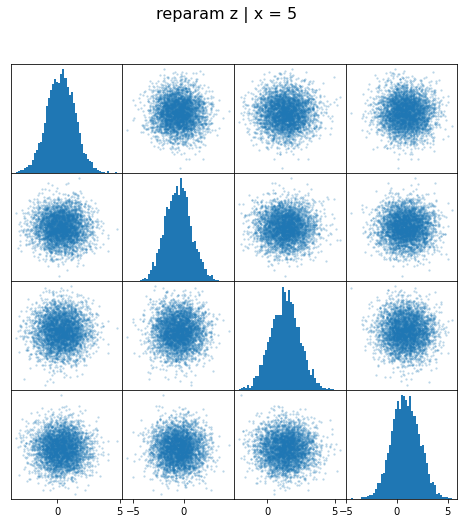

In [48]:
for i in range(len(quantiles)):
    plot_pairs(i, z_unconstrained_svi)

## Fitting a conditional normalizing flow

Let's fit a conditional normalizing flow that depends only on the data point. In a real application we'd want to additionally depend on the local parameters of the stable distribution (stability, skew, scale, and loc).

In [241]:
class FlowGuide(PyroModule):
    def __init__(self, data: torch.Tensor):
        super().__init__()
        self.transforms = torch.nn.ModuleList([
            dist.transforms.conditional_planar(
                input_dim=4, context_dim=1
            )
            for _ in range(1)
        ])

    def forward(self, data: torch.Tensor):
        with pyro.plate_stack("data", data.shape):
            base_dist = dist.Normal(torch.zeros(4), 1).to_event(1)
            z_dist = dist.TransformedDistribution(
                base_dist,
                [t.condition(data[..., None]) for t in self.transforms],
            )
            z_unconstrained = pyro.sample(
                "z", z_dist, infer={"is_auxiliary": True},
            )
            z_u, z_e, t_u, t_e = z_unconstrained.unbind(-1)
            z_u = z_u.sigmoid()
            z_e = z_e.exp()
            t_u = t_u.sigmoid()
            t_e = t_e.exp()
            pyro.sample("x_z_uniform", dist.Delta(z_u))
            pyro.sample("x_z_exponential", dist.Delta(z_e))
            pyro.sample("x_t_uniform", dist.Delta(t_u))
            pyro.sample("x_t_exponential", dist.Delta(t_e))
        return z_unconstrained

In [242]:
pyro.clear_param_store()
pyro.set_rng_seed(20231007)

num_steps = 1001
guide = FlowGuide(data)
elbo = Trace_ELBO()
optim = ClippedAdam({"lr": 0.001, "lrd": 0.1**(1 / num_steps)})
svi = SVI(model, guide, optim, elbo)
losses = []
for step in range(num_steps):
    loss = svi.step(data) / len(data)
    losses.append(loss)
    if step % 100 == 0:
        print(f"step: {step: >4d} loss: {loss:0.5g}")

plt.plot(losses)
plt.ylim(min(losses), losses[0])

step:    0 loss: 1.8701
step:  100 loss: -1.3288
step:  200 loss: -1.4961
step:  300 loss: 169.24
step:  400 loss: -1.4726
step:  500 loss: -1.6813
step:  600 loss: -1.7189
step:  700 loss: -1.8202
step:  800 loss: -1.7555
step:  900 loss: -1.7603
step: 1000 loss: -1.7972


In [244]:
num_samples = 4000
with torch.no_grad():
  z_unconstrained = guide(torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0]).expand(num_samples, -1))
z_unconstrained.shape

torch.Size([4000, 5, 4])

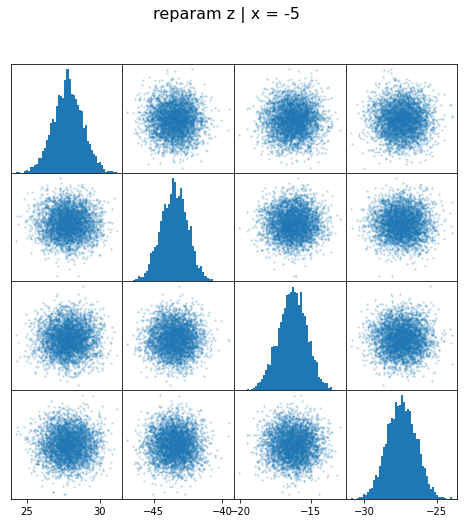

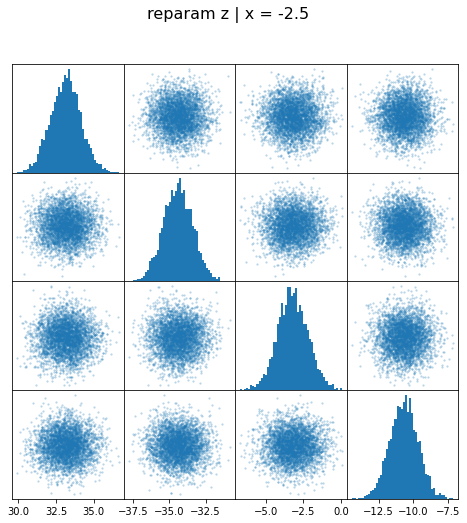

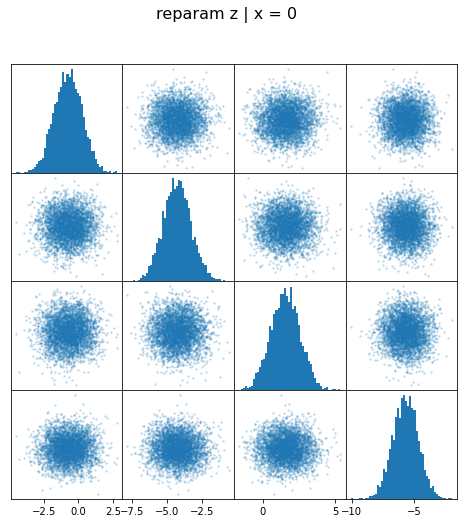

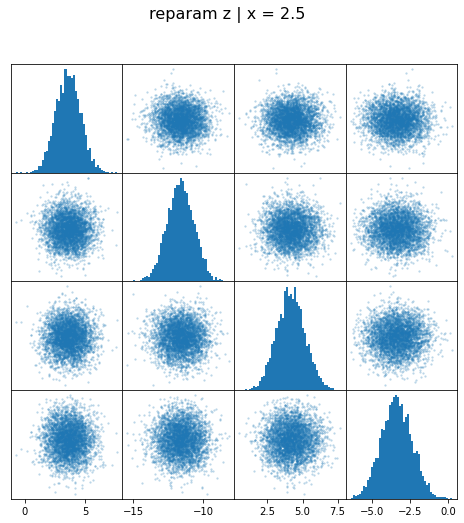

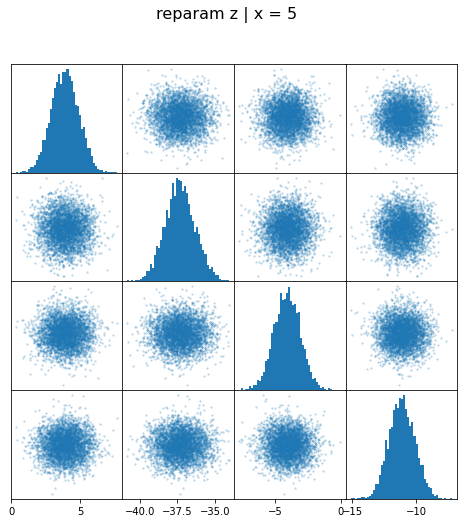

In [245]:
for i in range(len(quantiles)):
  plot_pairs(i)

Something is going wrong :-/